# Machine learning with graphs

## Assignment 4 (23/03/2021)

Solution notebook for Homeworks proposed in the MLG in the seminar of 2021 based on Machine learning with graphs course by Standford university.

Author: Daniel Bacaicoa Barber (13 mar, 2021)

In [1]:
#Importing generic libraries.
import numpy as np
import pandas as pd
import scipy 

# Graph related libraries 
import networkx as nx

# Util libraries
from collections import Counter, OrderedDict
import itertools
import random

#Plotting library
import matplotlib.pyplot as plt

<font color='red'> In this notebook several graphs are provided to play with the Louvain algorithm</font>

### 3 Community detection using the Louvain algorithm

**Note:** For this question, assume all graphs are undirected and weighted.

Communities are a fundamental aspect of several networks. However, it is often not an easy task
to come up with an "optimal" grouping of nodes into communities. Through this problem, we will
explore some properties of the Louvain algorithm for community detection (so named because the
authors were all affiliated with the University of Louvain in Belgium at some point). The original
paper from Blondel et al. is available here: https://arxiv.org/pdf/0803.0476.pdf. If you are
stuck on this question at any point please refer to the paper; there is a good chance that you will
find what you seek there.

We will first explore the idea of modularity. The modularity of a weighted graph is a measure that
compares the density of edges within a community to the density of edges between communities.
Formally, we define the modularity $Q$ for a given graph as follows:

$$ Q=\frac{1}{2m}\displaystyle \sum_{1\leq i,j,\leq n}\left( \left[ A_{ij} - \frac{\delta_i\delta_j}{2m}\right] \delta(c_i,c_j)\right) $$

Here $2m = \sum A_{ij}$ is the sum of all entries in the adjacency matrix, $A_{ij}$ represents the $(i, j)^{th}$ entry
of the adjacency matrix, $d_i$ represents the degree of node $i$, $\delta(c_i, c_j)$ is $1$ when $i$ and $j$ are in the
same community $(c_i = c_j)$ and $0$ otherwise. Note that we treat communities as disjoint. In other
words, a given node from a graph can only belong to one community in that graph.

The modularity of a graph lies in the range $[-1, 1]$. Maximizing the modularity of a given graph is
a computationally hard problem, so we try different heuristics for this purporse. One such heuristic
is the **Louvain algorithm**. This algorithm outperforms many similar algorithms in terms of both
speed as well as maximum modularity obtained. We will run a few steps of the algorithm on a
couple of example networks to gain some insights about its behavior and properties.

Each pass of the algorithm has two phases, and proceeds as follows:

<div class="alert alert-block alert-success">
<b>Comments:</b> We will load two different networks to perform the computatiosn even if the exercise was posed theoretically.
    
> We upload the <b>Football</b> and <b>Karate</b> networks
</div>

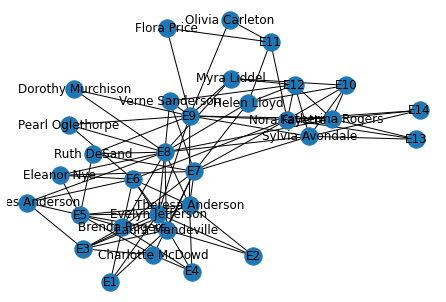

In [8]:
Karate = nx.karate_club_graph()

nx.draw(Karate, with_labels=True)
plt.show()

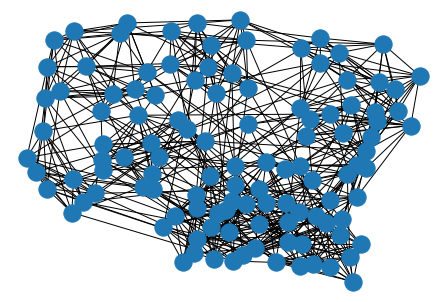

In [10]:
import urllib.request as urllib
import io
import zipfile

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
Football = nx.parse_gml(gml)  # parse gml data

nx.draw(Football, with_labels=False)
plt.show()

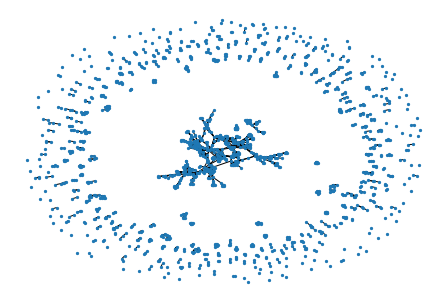

In [122]:
Netscience = nx.read_gml("netscience.gml")
nx.draw(Netscience,node_size = 5,arrowsize = 10)

- **Phase 1 (Modularity Optimization)**: Start with each node in its own community.

- For each node $i$, go over all the neighbors $j$ of $i$. Calculate the change in modularity when $i$
is moved from its present community to $j's$ community. Find the neighbor $j_m$ for which this
process causes the greatest increase in modularity, and assign $i$ to $j_m's$ community (break
ties arbitrarily). If there is no positive increase in modularity during this process, keep $i$ in
its original community.

- Repeat the above process for each node (going over nodes multiple times if required) until
there is no further maximization possible (that is, each node remains in its community). This
is the end of Phase 1.

- **Phase 2 (Community Aggregation)**: Once Phase 1 is done, we contract the original
graph $G$ to a new graph $H$. Each community found in $G$ after Phase 1 becomes a node in $H$.
The weights of edges in between 2 nodes in $H$ are given by the sums of the weights between
the respective 2 communities in $G$. The weights of edges within a community in $G$ sum up
to form a self-edge of the same weight in $H$ (be careful while calculating self-edge weights,
note that you will have to go once over each original node within the community in $G$). This
is the end of Phase 2. Phase 1 and Phase 2 together make up a single pass of the algorithm.

- Repeat Phase 1 and Phase 2 again on H and keep proceeding this way until no further
improvement is seen (you will reach a point where each node in the graph stays in its original
community to maximize modularity). The final modularity value is a heuristic for the
maximum modularity of the graph.

<img src="Figure_1.png">
<center>Figure 1: Example from Blondel et al. showing the two phases of the Louvain algorithm.<br> Note
how weights for self-edges are assigned in the Community Aggregation phase.</center>

An example taken from Blondel et al. (Figure 1) illustrates the two phases of the algorithm. Note
how weights for self-edges are assigned in the Community Aggregation phase - we will need to use
this later. The weight of the self-edge formed by merging all nodes in a community $K$ would be
given by $\sum_{i\in K}\sum_{j\in K}A_{ij}$ - you can verify this for yourself by checking in Figure 1 that node 11 and
13 have an edge of weight 1 between them, but the corresponding self-edge has a weight of 2.

#### 3.1 Modularity gain when an isolated node moves into a community

Consider a node $i$ that is in a community all by itself. Let $C$ represent an existing community
in the graph. Node $i$ feels lonely and decides to move into the community $C$, we will inspect the
change in modularity when this happens.

This situation can be modeled by a graph (Figure 2) with $C$ being represented by a single node. $C$
has a self-edge of weight $\sum_{in}$. There is an edge between $i$ and $C$ of weight $k_{i,in}/2$ (to stay consistent
with the notation of the paper). The total degree of $C$ is $\sum_{tot}$ and the degree of $i$ is $k_i$. As always,
$2m = \sum A_{ij}$ is the sum of all entries in the adjacency matrix. To begin with, $C$ and $i$ are in separate
communities (colored green and red respectively). Prove that the modularity gain seen when $i$
merges with $C$ (i.e., the change in modularity after they merge into one community) is given by:

$$
\Delta Q = \left[ \frac{\sum_{in}+k_{i,in}}{2m} - \left(\frac{\sum_{tot}+k_{i}}{2m}\right)^2\right]-
\left[\frac{\sum_{in}}{2m}- \left(\frac{\sum_{tot}}{2m}\right)^2 -\left(\frac{k_{i}}{2m}\right)^2\right]
$$

<div class="alert alert-block alert-info">
<b>Hint:</b> Using the community aggregation step of the Louvain method may make computation easier.</div>

In practice, this result is used while running the Louvain algorithm (along with a similar related
result) to make incremental modularity computations much faster.

<img src="Figure_2.png">
<center>Figure 2: Before merging, $i$ is an isolated node and $C$ represents an existing community.<br> The rest
of the graph can be treated as a single node for this problem.</center>

#### 3.2 Louvain algorithm on a 16 node network

Consider the graph $G$ (Figure 3), with 4 cliques of 4 nodes each arranged in a ring. Assume all the
edges have same weight value 1. There exists exactly one edge between any two adjacent cliques.
We will manually inspect the results of the Louvain algorithm on this network. The first phase of
modularity optimization detects each clique as a single community (giving 4 communities in all). After the community aggregation phase, the new network $H$ will have 4 nodes

<img src="Figure_3.png">
<center>Figure 3: $G$ is a graph with 16 nodes (4 cliques with 4 nodes per clique).</center>

In [148]:
def genearte_4clique_circle(cliques=4):
    i = 0
    edges = []
    for i in range(cliques):
        edges = edges + [*itertools.combinations(range(4*i ,4*i+4),2)]
        nodes = cliques*4
        edges = edges + [(j*5-int(np.floor(i/4)*4),1) if j == (cliques-1) else
                         (j*5-int(np.floor(i/4)*4),(j*5-int(np.floor(i/4)*4)+4)%(nodes)) 
                         for i,j in enumerate(range(0,cliques))]
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

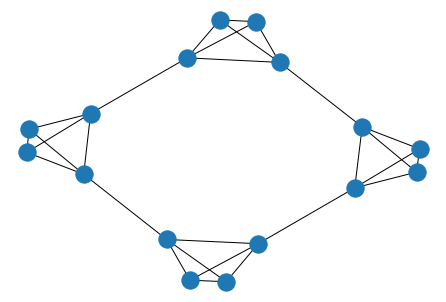

In [159]:
G_4 = genearte_4clique_circle(cliques=4)
nx.draw(G_4)

- What is the weight of any edge between two distinct nodes in $H$?

- What is the weight of any self-edge in $H$? 

- What is the modularity of H (with each node in its own community)? The easiest way to
calculate modularity would be to directly apply the definition from Figure 1 to $H$ (also holds for
upcoming questions of this type).

<div class="alert alert-block alert-danger">
<b>Spoiler alert:</b> In this network, this is the maximum modularity and the algorithm will terminate
here. However, assume that we wanted to contract the graph further into a two node network
(call it $J$) by grouping two adjacent nodes in $H$ into one community and the other two adjacent
nodes into another community, and then aggregating (following the same rules of the community
aggregation phase).
</div>

- What is the weight of any edge between two distinct nodes in $J$?

- What is the weight of any self-edge in $J$?

- What is the modularity of $J$ (with each node in its own community)?

As expected, the modularity of $J$ is less than the modularity of $H$.

#### 3.3 Louvain algorithm on a 128 node network

Now consider a larger version of the same network, with 32 cliques of 4 nodes each (arranged in
a ring as earlier); call this network $G_{big}$. Again, assume all the edges have same weight value 1,
and there exists exactly one edge between any two adjacent cliques. The first phase of modularity
optimization, as expected, detects each clique as a single community. After aggregation, this forms
a new network $H_{big}$ with 32 nodes.

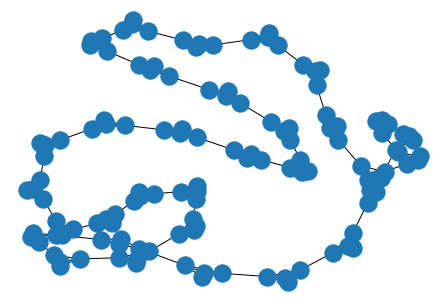

In [160]:
G_32 = genearte_4clique_circle(cliques=32)
nx.draw(G_32)

- What is the weight of any edge between two distinct nodes in $H_{big}$?

- What is the weight of any self-edge in $H_{big}$?


- What is the modularity of $H_{big}$ (with each node in its own community)?


After what we saw in the earlier example, we would expect the algorithm to terminate here.
However (spoiler alert again), that doesn't happen and the algorithm proceeds. The next phase
of modularity optimization groups $H_{big}$ into 16 communities with two adjacent nodes from $H_{big}$ in
each community. Call the resultant graph (after community aggregation) $J_{big}$.


- What is the weight of any edge between two distinct nodes in $J_{big}$?

- What is the weight of any self-edge in $J_{big}$?

- What is the modularity of $J_{big}$ (with each node in its own community)?

This particular grouping of communities corresponds to the maximum modularity in this network
(and not the one with one clique in each community). The community grouping that maximizes the
modularity here corresponds to one that would not be considered intuitive based on the structure
of the graph.

#### 3.4 What just happened?

Explain (in a few lines) why you think the algorithm behaved the way it did for the larger network
(you don't need to prove anything rigorously, a rough argument will do). In other words, what
might have caused modularity to be maximized with an ''unintuitive'' community grouping for the
larger network?

What to subbmit


Page 7:  Proof for change in modularity when node i moves to community C.

Page 8:  Weight of edge between two distinct nodes in H.

CS224W: Machine Learning with Graphs - Homework 1 11

 Weight of self-edge in H.

 Modularity of H with each node in its own community.

 Weight of edge between two distinct nodes in J.

 Weight of self-edge in J.

 Modularity of J with each node in its own community.

Page 9:  The same as above, except for Hbig and Jbig.

Page 10:  Explanation of algorithm behavior in the larger network (a few lines).

In [2]:
Commit = False

message = "Message here"

if Commit:
    git add Assignment_4.ipynb
    git commit -m message 
    git push
else:
    

SyntaxError: invalid syntax (<ipython-input-2-f819f5766a29>, line 6)